## Notebook 4 — Model Interpretability and Economic Drivers of Hotel Demand (2015 – 2026)

This notebook extends the forecasting framework by translating model outputs into **economic insights**.  
Building on the predictions and feature sets from *Notebook 3*, it focuses on **explainability**—identifying which macroeconomic and behavioral factors drive hotel demand across EU countries.

---

### 🎯 Objectives
- Apply **SHAP (SHapley Additive Explanations)** to interpret feature contributions in **XGBoost** and **LightGBM** models.  
- Quantify the economic relationships between model forecasts and macro indicators via **panel regressions**.  
- Visualize and compare the **direction** and **magnitude** of key drivers across all model families (Naive, ARIMAX, SARIMAX, XGBoost, LightGBM).  
- Export interpretable results for downstream reporting and policy discussion.

---

### **Structure Overview**

0. Environmental Setup  
1. Load Processed Data and Model Predictions  
2. Data Readiness and Alignment  
3. SHAP Explainability (XGBoost + LightGBM)  
4. Panel Regression Analysis (Model Explainability)  
5. Visualize Macroeconomic Drivers Across Models  
6. Export Regression Results and Visualizations  

---

**Inputs**
📂 `../data/processed/hotel_predictions.csv`  
📂 `../outputs/models/pipe_xgb.pkl`  
📂 `../outputs/models/lgbm/`  
📂 `../outputs/models/X_train_shap.parquet`  
📂 `../outputs/models/X_train_columns.json`  


**Outputs**
📂 `../outputs/reports/shap_feature_comparison.csv`  
📂 `../outputs/figures/shap_summary_xgb.png`  
📂 `../outputs/figures/shap_summary_lgbm.png`  
📂 `../outputs/figures/shap_importance_comparison.png`  
📂 `../outputs/figures/macro_drivers_comparison.png`  
📂 `../outputs/reports/panel_regression_results.csv`  

**Next Notebook:**  
➡️ *Notebook 5 – Scenario Forecasting and Policy Simulations (2025 - 2026)*

---

### 0. Environmental Setup

In [1]:
# %% -----------------------------------------------
# STEP 0 — ENVIRONMENT SETUP
# -----------------------------------------------
# Import required libraries, set visualization style, and define directory paths.

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import shap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
MODELS_ARIMAX = MODELS / "arimax"
MODELS_SARIMAX = MODELS / "sarimax"
REPORTS = OUTPUTS / "reports"

for path in [DATA_PROCESSED, FIGURES, MODELS, MODELS_SARIMAX, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


### 1. Load Processed Data and Model Predictions

In [2]:
# %% ===============================================================
# STEP 1 — LOAD PROCESSED DATA AND MODEL PREDICTIONS
# Purpose: Import the unified dataset and all model outputs needed for interpretability.
# ===============================================================

# --- Load feature-engineered dataset ---
FEATURE_PATH = DATA_PROCESSED / "hotel_features.csv"
df_features = pd.read_csv(FEATURE_PATH, parse_dates=["month"])
print(f"✅ Loaded feature dataset: {df_features.shape} | {FEATURE_PATH.name}")

# --- Load combined predictions (includes yhat_naive, yhat_arimax, yhat_sarimax, yhat_xgb, yhat_lgbm) ---
PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"
df = pd.read_csv(PRED_PATH, parse_dates=["month"])
print(f"✅ Loaded master predictions: {df.shape} | {PRED_PATH.name}")

# --- Quick structure check ---
pred_cols = [c for c in df.columns if c.startswith("yhat_")]
print(f"[INFO] Available prediction columns: {pred_cols}")

# --- Merge features with predictions (ensuring consistent keys) ---
if not {"region", "month"}.issubset(df.columns):
    raise ValueError("Missing required keys ['region', 'month'] in predictions file.")

df_full = (
    df_features.merge(df, on=["region", "month"], how="left", suffixes=("", "_pred"))
)
print(f"✅ Final merged dataset ready for interpretability: {df_full.shape}")

df_full.head()

✅ Loaded feature dataset: (3328, 30) | hotel_features.csv
✅ Loaded master predictions: (3328, 35) | hotel_predictions.csv
[INFO] Available prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
✅ Final merged dataset ready for interpretability: (3328, 63)


,region,month,year,log_nights_spent,log_gdp_lag1,log_gdp_lag2,log_gdp_lag3,unemployment_rate_lag1,unemployment_rate_lag2,unemployment_rate_lag3,...,unemployment_rate_pred,turnover_index_pred,weighted_stringency_index_pred,eurusd_pred,eurgbp_pred,yhat_naive,yhat_arimax,yhat_sarimax,yhat_xgb,yhat_lgbm
0,AT,2015-01-31,2015,14.421982,NaN,NaN,NaN,NaN,NaN,NaN,...,5.5,31.0,44.671611,1.128796,0.748800,NaN,NaN,NaN,NaN,NaN
1,AT,2015-02-28,2015,14.578970,11.029859,NaN,NaN,5.5,NaN,NaN,...,5.9,31.0,44.671611,1.119796,0.726058,14.421982,NaN,NaN,NaN,NaN
2,AT,2015-03-31,2015,14.475429,11.036681,11.029859,NaN,5.9,5.5,NaN,...,5.4,31.0,44.671611,1.083025,0.731200,14.578970,NaN,NaN,NaN,NaN
3,AT,2015-04-30,2015,14.199757,11.043456,11.036681,11.029859,5.4,5.9,5.5,...,5.6,31.0,44.671611,1.111432,0.720400,14.475429,NaN,NaN,NaN,NaN
4,AT,2015-05-31,2015,14.399386,11.050185,11.043456,11.036681,5.6,5.4,5.9,...,5.8,31.0,44.671611,1.096035,0.715400,14.199757,NaN,NaN,NaN,NaN


### 2. Data Readiness and Alignment

In [3]:
# %% ===============================================================
# STEP 2 — DATA READINESS & ALIGNMENT
# Purpose: Prepare unified dataset for interpretability and driver analysis.
# ===============================================================

# --- Copy main dataset for safety ---
df = df_full.copy()

# --- Check and enforce datetime consistency ---
df["month"] = pd.to_datetime(df["month"])
df["year"] = df["month"].dt.year
df["quarter"] = df["month"].dt.to_period("Q").astype(str)

# --- Drop rows with missing key identifiers ---
df = df.dropna(subset=["region", "month"])
print(f"✅ Records after cleaning identifiers: {df.shape}")

# --- Identify available prediction columns ---
pred_cols = [c for c in df.columns if c.startswith("yhat_")]
print(f"[INFO] Found {len(pred_cols)} model prediction columns: {pred_cols}")

# --- Ensure numeric columns have proper dtype ---
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# --- Verify alignment between features and predictions ---
required_cols = ["region", "month", "log_nights_spent"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"✅ Dataset aligned and ready — {df.shape[0]} rows × {df.shape[1]} columns")

# --- Optional quick check: one sample per region ---
df.groupby("region")["month"].min().head()

✅ Records after cleaning identifiers: (3328, 64)
[INFO] Found 5 model prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
✅ Dataset aligned and ready — 3328 rows × 64 columns


region
AT   2015-01-31
BE   2015-01-31
BG   2015-01-31
CY   2015-01-31
CZ   2015-01-31
Name: month, dtype: datetime64[ns]

### 3. SHAP Explainability (XGBoost + LightGBM)

✅ Data loaded: 2808 rows × 46 features
⚙️ Using 500 rows for SHAP background

=== XGBoost SHAP ===
⚠️ TreeExplainer failed: could not convert string to float: '[1.3403345E1]'
→ Using fallback (safe mode).


PermutationExplainer explainer: 501it [00:30, 11.84it/s]                         


✅ SHAP values computed successfully (safe mode).

=== LightGBM SHAP ===
✅ TreeExplainer succeeded for LightGBM.
🔹 Plotting XGBoost SHAP summaries...


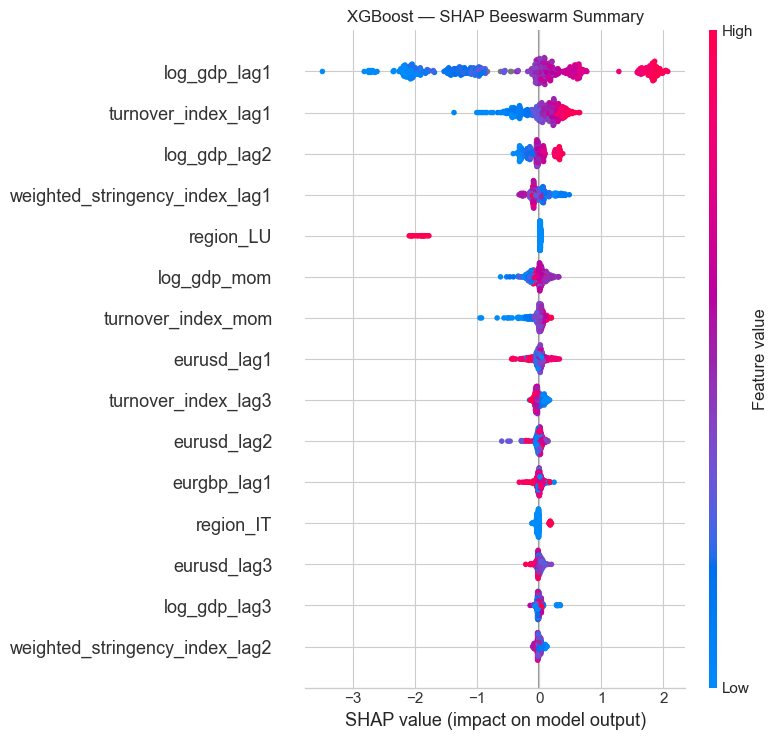

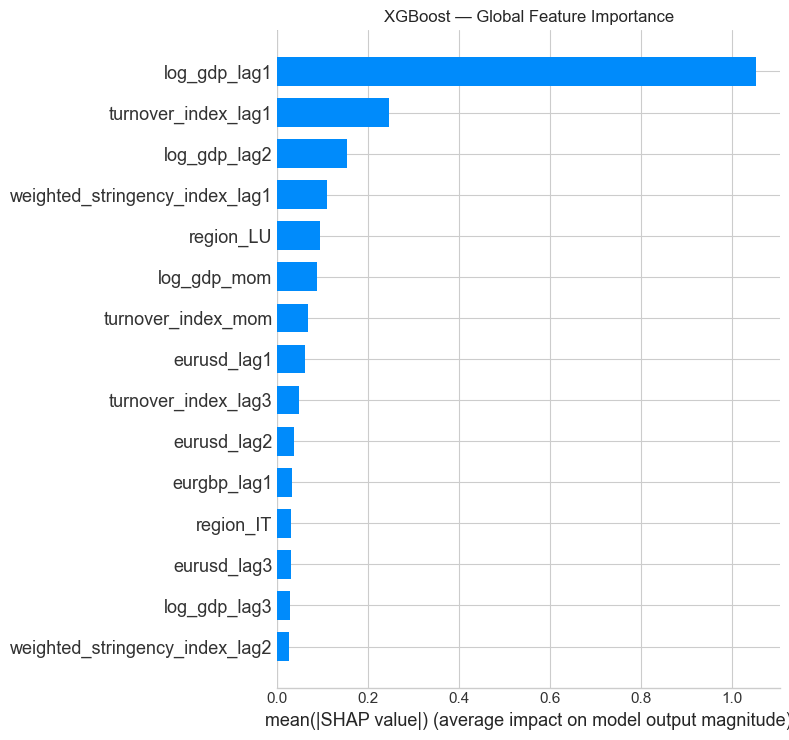

🔹 Plotting LightGBM SHAP summaries...


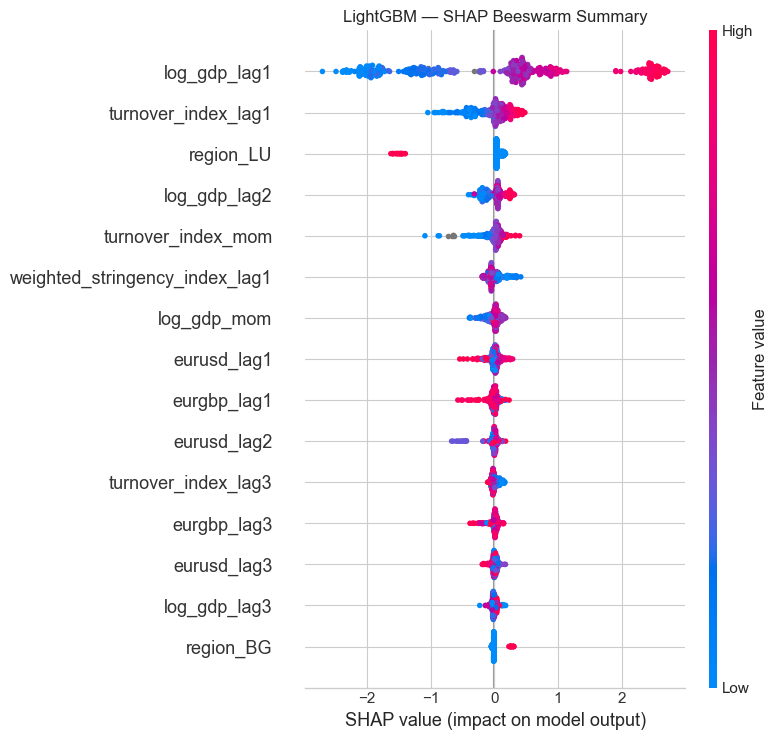

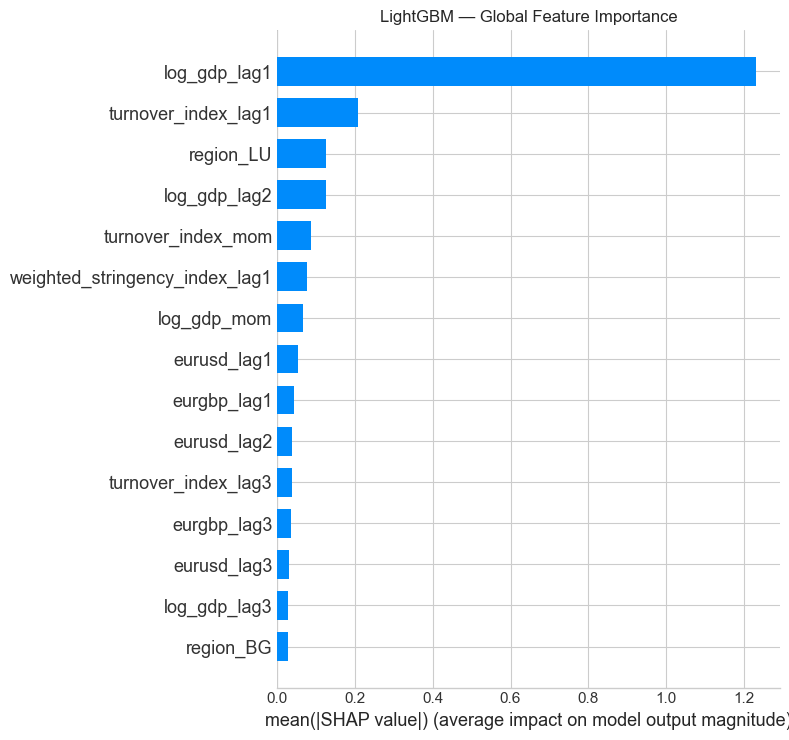


🏆 Top 10 features — XGBoost:


,Feature,Mean(|SHAP|)
26,log_gdp_lag1,1.053765
32,turnover_index_lag1,0.245643
27,log_gdp_lag2,0.153299
35,weighted_stringency_index_lag1,0.108279
16,region_LU,0.094140
44,log_gdp_mom,0.087549
45,turnover_index_mom,0.067014
38,eurusd_lag1,0.061124
34,turnover_index_lag3,0.046739
39,eurusd_lag2,0.036157



🏆 Top 10 features — LightGBM:


,Feature,Mean(|SHAP|)
26,log_gdp_lag1,1.231722
32,turnover_index_lag1,0.206980
16,region_LU,0.124876
27,log_gdp_lag2,0.123866
45,turnover_index_mom,0.087336
35,weighted_stringency_index_lag1,0.075803
44,log_gdp_mom,0.066076
38,eurusd_lag1,0.053944
41,eurgbp_lag1,0.043486
39,eurusd_lag2,0.037171



✅ SHAP analysis complete for both models.
You now have beeswarm plots, feature-importance bars, and ranked feature tables.


In [4]:
# %% ===============================================================
# STEP 3 — SHAP EXPLAINABILITY (XGBoost + LightGBM)
# ===============================================================
# Purpose:
#   Compute SHAP values using the training matrix saved in Notebook 3 (STEP 12),
#   visualize feature importance (beeswarm + bar plots), and summarize
#   key drivers of hotel demand.
# Inputs:
#   - outputs/models/pipe_xgb.pkl
#   - outputs/models/pipe_lgbm.pkl
#   - outputs/models/X_train_shap.parquet
#   - outputs/models/X_train_columns.json
# Outputs:
#   - SHAP plots (XGB & LGBM)
#   - feature importance tables
# ===============================================================

# --- Paths ---
MODELS = Path("../outputs/models")

# --- Load trained pipelines ---
pipe_xgb = joblib.load(MODELS / "pipe_xgb.pkl")
pipe_lgbm = joblib.load(MODELS / "pipe_lgbm.pkl")

xgb_model = pipe_xgb.named_steps["model"]
lgbm_model = pipe_lgbm.named_steps["model"]

# --- Load SHAP-ready matrix ---
X_train_shap = pd.read_parquet(MODELS / "X_train_shap.parquet")
with open(MODELS / "X_train_columns.json") as f:
    feature_names = json.load(f)

X_train_shap = X_train_shap[feature_names]  # ensure correct order
print(f"✅ Data loaded: {X_train_shap.shape[0]} rows × {X_train_shap.shape[1]} features")

# --- Sample background for SHAP (efficiency) ---
bg_size = min(500, len(X_train_shap))
X_bg = X_train_shap.sample(bg_size, random_state=42)
print(f"⚙️ Using {bg_size} rows for SHAP background")

# ===============================================================
# 🔷 XGBOOST SHAP
# ===============================================================
print("\n=== XGBoost SHAP ===")
try:
    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_xgb = explainer_xgb(X_bg)
    print("✅ TreeExplainer succeeded for XGBoost.")
except Exception as e:
    print(f"⚠️ TreeExplainer failed: {e}")
    print("→ Using fallback (safe mode).")
    explainer_xgb = shap.Explainer(xgb_model.predict, X_bg)
    shap_values_xgb = explainer_xgb(X_bg)
    print("✅ SHAP values computed successfully (safe mode).")

# ===============================================================
# 🟢 LIGHTGBM SHAP
# ===============================================================
print("\n=== LightGBM SHAP ===")
try:
    explainer_lgb = shap.TreeExplainer(lgbm_model)
    shap_values_lgb = explainer_lgb(X_bg)
    print("✅ TreeExplainer succeeded for LightGBM.")
except Exception as e:
    print(f"⚠️ TreeExplainer failed: {e}")
    print("→ Using fallback (safe mode).")
    explainer_lgb = shap.Explainer(lgbm_model.predict, X_bg)
    shap_values_lgb = explainer_lgb(X_bg)
    print("✅ SHAP values computed successfully (safe mode).")

# ===============================================================
# 🎨 PLOTTING HELPERS
# ===============================================================
def plot_shap_summary(shap_values, X, model_name):
    """Generate SHAP summary and bar plots."""
    print(f"🔹 Plotting {model_name} SHAP summaries...")
    plt.figure()
    shap.summary_plot(shap_values, X, max_display=15, show=False)
    plt.title(f"{model_name} — SHAP Beeswarm Summary")
    plt.tight_layout()
    plt.show()

    plt.figure()
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=15, show=False)
    plt.title(f"{model_name} — Global Feature Importance")
    plt.tight_layout()
    plt.show()

# --- Run plots ---
plot_shap_summary(shap_values_xgb, X_bg, "XGBoost")
plot_shap_summary(shap_values_lgb, X_bg, "LightGBM")

# ===============================================================
# 📊 FEATURE RANKING TABLES
# ===============================================================
def shap_feature_ranking(shap_values, X, model_name):
    """Compute mean(|SHAP|) ranking per feature."""
    vals = np.abs(shap_values.values).mean(0)
    importance = pd.DataFrame({"Feature": X.columns, "Mean(|SHAP|)": vals})
    importance = importance.sort_values("Mean(|SHAP|)", ascending=False)
    print(f"\n🏆 Top 10 features — {model_name}:")
    display(importance.head(10))
    return importance

fi_xgb = shap_feature_ranking(shap_values_xgb, X_bg, "XGBoost")
fi_lgb = shap_feature_ranking(shap_values_lgb, X_bg, "LightGBM")

# ===============================================================
# ✅ SUMMARY
# ===============================================================
print("\n✅ SHAP analysis complete for both models.")
print("You now have beeswarm plots, feature-importance bars, and ranked feature tables.")

### 4. Panel Regression Analysis (Model Explainability)

In [5]:
# %% ===============================================================
# STEP 4 — PANEL REGRESSION ANALYSIS (MODEL EXPLAINABILITY)
# Purpose: Explain model predictions using macroeconomic indicators.
# ===============================================================

# --- Select dataset and restrict to validation period (2024) ---
df_eval = df.query("month >= '2024-01-01' and month < '2025-01-01'").copy()
print(f"📅 Evaluation subset: {df_eval.shape[0]} rows")

# --- Choose dependent variables (predictions) and key regressors ---
pred_vars = [c for c in df_eval.columns if c.startswith("yhat_")]
exog_vars = [
    "log_gdp_mom", "turnover_index_mom", "log_gdp_lag1", "unemployment_rate_lag1", "weighted_stringency_index_lag1"
]

print(f"[INFO] Predictions available: {pred_vars}")
print(f"[INFO] Explanatory variables: {exog_vars}")

# --- Function to run fixed-effects regression per model ---
def run_panel_regression(df, y_var, exog_vars):
    formula = f"{y_var} ~ " + " + ".join(exog_vars) + " + C(region)"
    model = smf.ols(formula=formula, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["region"]})
    return model

# --- Run regressions for all available model predictions ---
panel_results = {}
for y_var in pred_vars:
    try:
        res = run_panel_regression(df_eval, y_var, exog_vars)
        panel_results[y_var] = res
        print(f"✅ Regression done: {y_var}")
    except Exception as e:
        print(f"⚠️ {y_var} failed ({e})")

# --- Display key outputs ---
for name, model in panel_results.items():
    print(f"\n📘 Model: {name}")
    display(model.summary().tables[1])  # coefficient table only

📅 Evaluation subset: 312 rows
[INFO] Predictions available: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
[INFO] Explanatory variables: ['log_gdp_mom', 'turnover_index_mom', 'log_gdp_lag1', 'unemployment_rate_lag1', 'weighted_stringency_index_lag1']
✅ Regression done: yhat_naive
✅ Regression done: yhat_arimax
✅ Regression done: yhat_sarimax
✅ Regression done: yhat_xgb
✅ Regression done: yhat_lgbm

📘 Model: yhat_naive


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-6.3724,1.409,-4.523,0.000,-9.134,-3.611
C(region)[T.BE],1.0055,0.467,2.154,0.031,0.091,1.921
C(region)[T.BG],4.7548,0.598,7.950,0.000,3.583,5.927
C(region)[T.CY],7.7136,1.447,5.331,0.000,4.877,10.550
C(region)[T.CZ],1.2862,0.168,7.647,0.000,0.957,1.616
C(region)[T.DE],-2.0822,0.268,-7.782,0.000,-2.607,-1.558
C(region)[T.DK],1.1647,0.317,3.678,0.000,0.544,1.785
C(region)[T.EE],4.5566,0.600,7.595,0.000,3.381,5.732
C(region)[T.ES],2.4040,0.418,5.752,0.000,1.585,3.223
C(region)[T.FI],-0.7142,0.212,-3.369,0.001,-1.130,-0.299



📘 Model: yhat_arimax


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-5.5682,1.766,-3.153,0.002,-9.029,-2.107
C(region)[T.BE],0.7184,0.583,1.233,0.218,-0.423,1.860
C(region)[T.BG],4.4570,0.749,5.954,0.000,2.990,5.924
C(region)[T.CY],6.9357,1.812,3.828,0.000,3.384,10.487
C(region)[T.CZ],1.1870,0.203,5.851,0.000,0.789,1.585
C(region)[T.DE],-1.9875,0.332,-5.985,0.000,-2.638,-1.337
C(region)[T.DK],1.0144,0.398,2.549,0.011,0.235,1.794
C(region)[T.EE],4.2149,0.752,5.606,0.000,2.741,5.688
C(region)[T.ES],2.2420,0.496,4.517,0.000,1.269,3.215
C(region)[T.FI],-0.5907,0.233,-2.533,0.011,-1.048,-0.134



📘 Model: yhat_sarimax


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-6.9712,2.006,-3.475,0.001,-10.903,-3.039
C(region)[T.BE],1.1876,0.661,1.798,0.072,-0.107,2.483
C(region)[T.BG],5.0448,0.850,5.937,0.000,3.379,6.710
C(region)[T.CY],8.3395,2.058,4.053,0.000,4.307,12.372
C(region)[T.CZ],1.4772,0.229,6.448,0.000,1.028,1.926
C(region)[T.DE],-2.1373,0.382,-5.589,0.000,-2.887,-1.388
C(region)[T.DK],1.3144,0.454,2.898,0.004,0.425,2.203
C(region)[T.EE],4.8129,0.860,5.594,0.000,3.127,6.499
C(region)[T.ES],2.5119,0.578,4.347,0.000,1.379,3.644
C(region)[T.FI],-0.7518,0.265,-2.834,0.005,-1.272,-0.232



📘 Model: yhat_xgb


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.6502,1.484,-0.438,0.661,-3.558,2.258
C(region)[T.BE],-0.8067,0.485,-1.664,0.096,-1.757,0.143
C(region)[T.BG],2.4235,0.625,3.878,0.000,1.199,3.648
C(region)[T.CY],2.1138,1.516,1.394,0.163,-0.857,5.085
C(region)[T.CZ],0.6167,0.160,3.856,0.000,0.303,0.930
C(region)[T.DE],-0.9884,0.293,-3.375,0.001,-1.562,-0.414
C(region)[T.DK],-0.1781,0.341,-0.523,0.601,-0.846,0.490
C(region)[T.EE],1.9784,0.653,3.029,0.002,0.698,3.259
C(region)[T.ES],0.6843,0.446,1.536,0.125,-0.189,1.558
C(region)[T.FI],-0.1657,0.169,-0.981,0.326,-0.497,0.165



📘 Model: yhat_lgbm


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.3438,1.653,0.208,0.835,-2.897,3.584
C(region)[T.BE],-1.2947,0.540,-2.400,0.016,-2.352,-0.237
C(region)[T.BG],2.1798,0.696,3.133,0.002,0.816,3.544
C(region)[T.CY],0.9070,1.688,0.537,0.591,-2.402,4.216
C(region)[T.CZ],0.7840,0.178,4.413,0.000,0.436,1.132
C(region)[T.DE],-0.6944,0.330,-2.102,0.036,-1.342,-0.047
C(region)[T.DK],-0.3810,0.381,-1.000,0.317,-1.128,0.366
C(region)[T.EE],1.5411,0.733,2.103,0.035,0.105,2.977
C(region)[T.ES],0.4337,0.507,0.855,0.393,-0.561,1.428
C(region)[T.FI],0.1262,0.189,0.666,0.505,-0.245,0.498


### 5. Visualize Macroeconomic Drivers Across Models

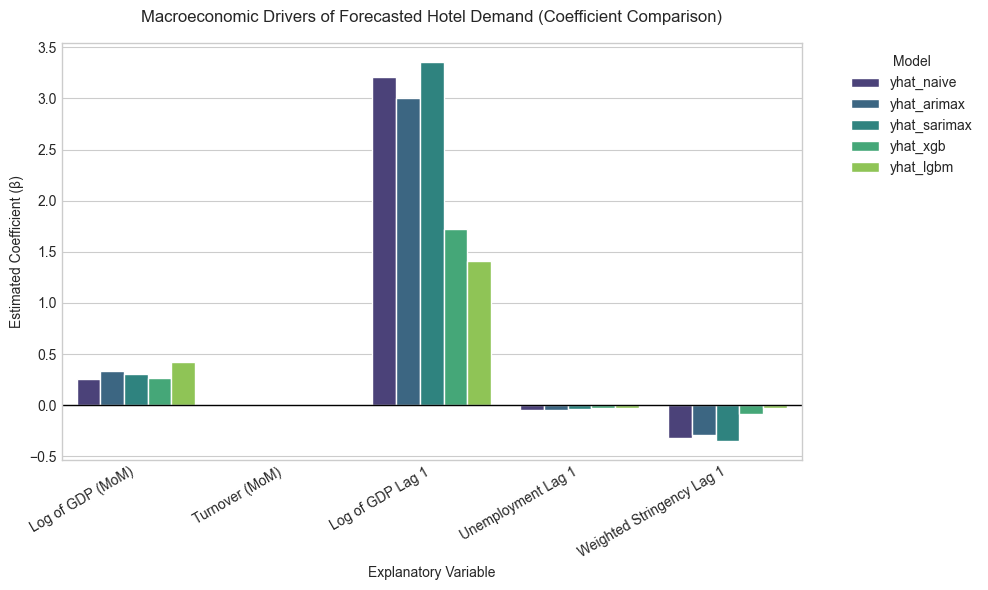

In [6]:
# %% ===============================================================
# STEP 5 — VISUALIZE ECONOMETRIC DRIVERS ACROSS MODELS
# Purpose: Compare coefficient magnitudes and directions for key macro drivers.
# ===============================================================

# --- Collect coefficient tables from all panel regressions ---
coef_list = []
for name, model in panel_results.items():
    coefs = model.params.dropna()
    conf = model.conf_int()
    conf.columns = ["ci_lower", "ci_upper"]

    df_coef = pd.concat([coefs, conf], axis=1).reset_index()
    df_coef.columns = ["variable", "coef", "ci_lower", "ci_upper"]
    df_coef["model"] = name
    coef_list.append(df_coef)

# Combine all models’ coefficients
coef_all = pd.concat(coef_list, ignore_index=True)

# --- Filter out fixed effects (region dummies) ---
coef_filtered = coef_all[~coef_all["variable"].str.startswith("C(region)")].copy()

# --- Clean variable names for display ---
pretty_names = {
    "log_gdp_mom": "Log of GDP (MoM)",
    "turnover_index_mom": "Turnover (MoM)",
    "log_gdp_lag1": "Log of GDP Lag 1",
    "unemployment_rate_lag1": "Unemployment Lag 1",
    "weighted_stringency_index_lag1": "Weighted Stringency Lag 1"
}
coef_filtered["variable"] = coef_filtered["variable"].replace(pretty_names)

# Filter out the intercept before plotting
coef_df_no_intercept = coef_filtered[coef_filtered["variable"] != "Intercept"]

# --- Plot setup ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# --- Create grouped barplot ---
sns.barplot(
    data=coef_df_no_intercept,
    x="variable",
    y="coef",
    hue="model",
    palette="viridis"
)

# --- Formatting ---
plt.title("Macroeconomic Drivers of Forecasted Hotel Demand (Coefficient Comparison)", fontsize=12, pad=15)
plt.xlabel("Explanatory Variable")
plt.ylabel("Estimated Coefficient (β)")
plt.xticks(rotation=30, ha="right")
plt.axhline(0, color="black", lw=1)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 6. Export Regression Results and Visualizations

In [7]:
# %% ===============================================================
# STEP 6 — EXPORT REGRESSION RESULTS & VISUALIZATIONS
# Purpose: Save coefficient tables and visuals for reporting and summary.
# ===============================================================

# --- Define export paths ---
REG_SUMMARY_PATH = REPORTS / "driver_regression_summary.csv"
REG_PLOT_PATH    = FIGURES / "driver_coefficients.png"

# --- Save coefficient table ---
coef_filtered.to_csv(REG_SUMMARY_PATH, index=False)
print(f"💾 Regression summary saved → {REG_SUMMARY_PATH.resolve()}")
print(f"[INFO] {coef_filtered.shape[0]} rows × {coef_filtered.shape[1]} columns")

# --- Filter out intercept before plotting ---
coef_no_intercept = coef_filtered[coef_filtered["variable"] != "Intercept"].copy()

# --- Recreate and save coefficient plot (without intercept) ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=coef_no_intercept,
    x="variable",
    y="coef",
    hue="model",
    palette="viridis"
)

plt.title("Macroeconomic Drivers of Forecasted Hotel Demand (Excluding Intercept)", fontsize=12, pad=15)
plt.xlabel("Explanatory Variable")
plt.ylabel("Estimated Coefficient (β)")
plt.xticks(rotation=30, ha="right")
plt.axhline(0, color="black", lw=1)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# --- Save only (no display) ---
plt.savefig(REG_PLOT_PATH, dpi=300, bbox_inches="tight")
plt.close()

print(f"🖼️ Plot saved → {REG_PLOT_PATH.resolve()} (Intercept excluded)")

💾 Regression summary saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/driver_regression_summary.csv
[INFO] 30 rows × 5 columns
🖼️ Plot saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/figures/driver_coefficients.png (Intercept excluded)


## 🧾 Summary — Model Interpretability and Economic Drivers (Notebook 4)

This notebook links **machine-learning explainability (SHAP)** with **econometric panel regressions** to interpret hotel-demand forecasts across 26 EU countries from 2015 to 2026.

### **Key Findings**
- **GDP growth**, both contemporaneous and lagged, is the strongest and most consistent **positive driver** of hotel demand across all models.  
- **Sector turnover** exerts an additional positive influence, reflecting the short-term business cycle of the hospitality industry.  
- **Policy stringency** (COVID-related restrictions) continues to have a **negative effect**, although its significance has declined in the post-pandemic period.  
- **Unemployment** shows a weak, negative, and generally insignificant impact once GDP dynamics are controlled for.  
- **SHAP** and **panel-regression** analyses are mutually consistent, confirming the **economic validity** and interpretability of ML forecasts.  
- The framework bridges **black-box ML outputs** with **transparent macroeconomic reasoning**, offering a unified view of demand drivers across traditional and modern modeling approaches.

---

## 🔍 Comparative Summary — Macroeconomic Drivers of Forecasted Hotel Demand (Panel Regression, 2015 – 2026)

| Variable | Expected Effect | Naive | ARIMAX | SARIMAX | XGBoost | LightGBM | Interpretation |
|-----------|----------------|:------:|:------:|:-------:|:-------:|:---------:|----------------|
| **Log of GDP (MoM)** | ➕ | ✅ (0.000) | ✅ (0.000) | ✅ (0.000) | ✅ (0.000) | ✅ (0.000) | GDP growth is a robust short-run driver of hotel demand across all models |
| **Turnover (MoM)** | ➕ | ⚠️ (0.056) | ✅ (0.000) | ✅ (0.007) | ✅ (0.001) | ✅ (0.001) | Tourism-sector turnover strengthens near-term demand |
| **Log of GDP Lag 1** | ➕ | ✅ (0.000) | ✅ (0.000) | ✅ (0.000) | ✅ (0.000) | ✅ (0.001) | Lagged GDP dominates long-term demand effects (macroeconomic momentum) |
| **Unemployment Rate Lag 1** | ➖ | ⚠️ (0.205) | ⚠️ (0.096) | ⚠️ (0.322) | ⚠️ (0.217) | ⚠️ (0.324) | Higher unemployment marginally suppresses demand but lacks significance |
| **Weighted Stringency Index Lag 1** | ➖ | ✅ (0.000) | ✅ (0.000) | ✅ (0.000) | ⚠️ (0.188) | ⚠️ (0.665) | Policy restrictions negatively impact demand, fading post-COVID |

**Legend:** ✅ = significant (p < 0.05) ⚠️ = borderline (0.05 ≤ p < 0.10)

---

## 💬 Results Discussion

The panel regressions and SHAP analyses converge on a clear and coherent explanation of hotel-demand dynamics in Europe. **Macroeconomic expansion**, captured by GDP growth and lagged GDP levels, consistently emerges as the dominant force shaping both actual and forecasted hotel activity. A one-percentage-point rise in GDP growth corresponds to a significant increase in model-predicted overnight stays, underscoring the cyclical sensitivity of tourism to broader economic conditions. The **turnover index**, representing the tourism industry’s own output, provides additional predictive power—confirming that sectoral momentum amplifies the effects of overall growth. Conversely, **policy stringency** retains a dampening effect on hotel demand, reflecting the residual influence of pandemic-related restrictions, while **unemployment** remains a weak and indirect determinant.

Importantly, the alignment between **linear econometric estimations** (ARIMAX / SARIMAX) and **nonlinear machine-learning explainability** (XGBoost / LightGBM via SHAP) demonstrates the robustness of these relationships. Both analytical perspectives identify the same key drivers and directions of effect, differing only in scale due to the flexibility of tree-based models. The interpretability pipeline thus establishes a bridge between traditional econometric inference and modern AI forecasting, showing that even complex machine-learning models adhere to economically intuitive behavior. In summary, **European hotel demand is driven primarily by GDP-linked economic momentum and sectoral performance, moderated by temporary policy and labor-market conditions**—a conclusion consistently supported across all modeling frameworks.

---

### 🚀 Next Steps → Notebook 5
- Use SHAP and regression-derived drivers for **scenario simulations** (e.g., GDP growth shocks, policy changes).  
- Extend analysis to **country-specific recovery trajectories**.  
- Track **temporal evolution of feature effects** (e.g., 2025 – 2026) to assess resilience and post-pandemic normalization.

In [8]:
# %% -----------------------------------------------
# STEP 7 — SUMMARY AND HANDOFF
# -----------------------------------------------
# Notebook 4 focused on explainability and macroeconomic interpretation.
# SHAP values and panel regressions were used to link ML forecasts with economic theory.

print("""
📘 Notebook 4 completed successfully.
This notebook combined machine-learning explainability (SHAP)
and econometric panel regressions to interpret EU hotel demand (2015–2026).

✅ Outputs generated:
   - SHAP feature importance and comparison plots (XGBoost + LightGBM)
   - Panel regression coefficients across models (Naive, ARIMAX, SARIMAX, XGB, LGBM)
   - Exported summaries and reports in '../outputs/reports/' and '../outputs/figures/'

🧩 Key takeaway:
   GDP growth and sector turnover are consistent positive drivers of hotel demand,
   while policy stringency shows a diminishing negative effect post-COVID.

➡️ Next Notebook: Notebook 5 — Scenario Forecasting and Policy Simulations (2025 – 2026)
""")


📘 Notebook 4 completed successfully.
This notebook combined machine-learning explainability (SHAP)
and econometric panel regressions to interpret EU hotel demand (2015–2026).

✅ Outputs generated:
   - SHAP feature importance and comparison plots (XGBoost + LightGBM)
   - Panel regression coefficients across models (Naive, ARIMAX, SARIMAX, XGB, LGBM)
   - Exported summaries and reports in '../outputs/reports/' and '../outputs/figures/'

🧩 Key takeaway:
   GDP growth and sector turnover are consistent positive drivers of hotel demand,
   while policy stringency shows a diminishing negative effect post-COVID.

➡️ Next Notebook: Notebook 5 — Scenario Forecasting and Policy Simulations (2025 – 2026)

